In [311]:
! pip install prophet

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from prophet import Prophet

import warnings

warnings.filterwarnings("ignore")

In [314]:
# Wise API, get currency rates from timestamp
import requests

url = "https://api.sandbox.transferwise.tech/v1/rates?source=EUR&target=USD&from=2019-01-13T14:53:01&to=2019-05-13T14:53:01&group=day"

payload={}
headers = {
  'Authorization': "<WISE API TOKEN HERE>",
  'Cookie': '__cf_bm=ADynNO3g2RwUmJv26lbMNyYkID_4mgXKyBS6ry.fnIA-1666434726-0-Ae0cMZVP50r6PrfUQwsSaSANMcH8ZVfoaHn/ZSuB7YYe8t26YDVDIDFNVoGoksn25nzeU/CUUW4Nq9aWASsE7Ok='
}

response = requests.request("GET", url, headers=headers, data=payload)
data = response.json()

In [315]:
df = pd.DataFrame.from_records(data)
# Some small data cleaning and moving
first_col = df.pop('time')
df.insert(0, 'Time Stamp', first_col)
df.head()

,Time Stamp,rate,source,target
0,2019-05-12T00:00:00+0000,1.12356,EUR,USD
1,2019-05-11T00:00:00+0000,1.12356,EUR,USD
2,2019-05-10T00:00:00+0000,1.12192,EUR,USD
3,2019-05-09T00:00:00+0000,1.11973,EUR,USD
4,2019-05-08T00:00:00+0000,1.11906,EUR,USD


In [317]:
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = df.pop('source')
indexedDataset = df.pop('target')

indexedDataset = df.set_index(['Time Stamp'])
indexedDataset.head(5)

,rate
Time Stamp,
2019-05-12,1.12356
2019-05-11,1.12356
2019-05-10,1.12192
2019-05-09,1.11973
2019-05-08,1.11906


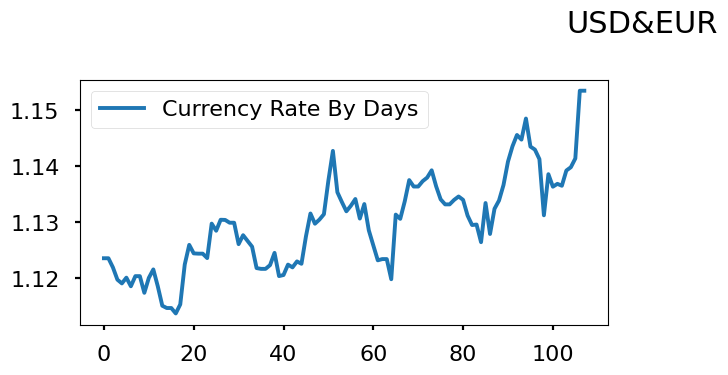

In [318]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('USD&EUR', fontsize=22)

plt.subplot(221)
plt.plot(df.rate, '-', label='Currency Rate By Days')
plt.legend()
plt.show()

In [319]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

                rate
Time Stamp          
2019-05-12       NaN
2019-05-11       NaN
2019-05-10       NaN
2019-05-09       NaN
2019-05-08       NaN
...              ...
2019-01-18  1.140458
2019-01-17  1.139977
2019-01-16  1.139696
2019-01-15  1.140110
2019-01-14  1.140942

[108 rows x 1 columns]                 rate
Time Stamp          
2019-05-12       NaN
2019-05-11       NaN
2019-05-10       NaN
2019-05-09       NaN
2019-05-08       NaN
...              ...
2019-01-18  0.004881
2019-01-17  0.004604
2019-01-16  0.004383
2019-01-15  0.005409
2019-01-14  0.006616

[108 rows x 1 columns]


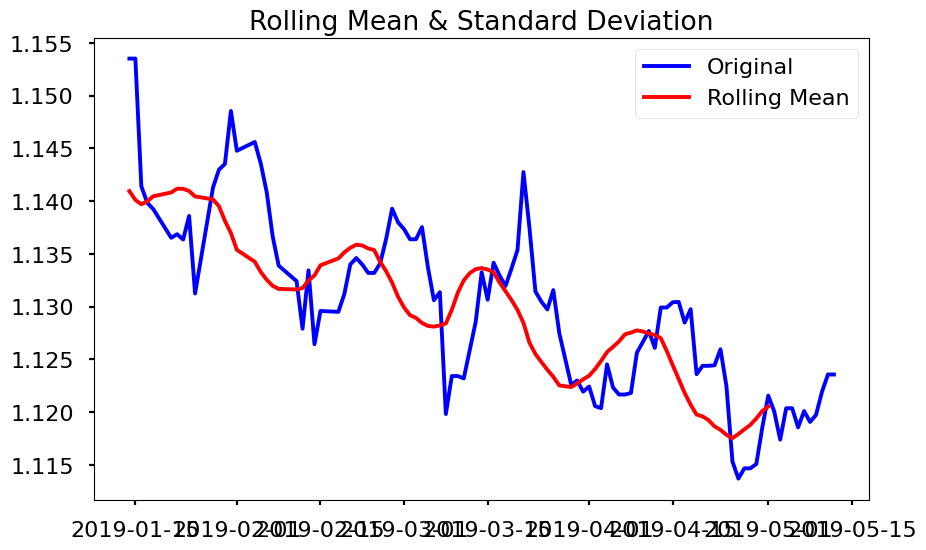

In [320]:


#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)



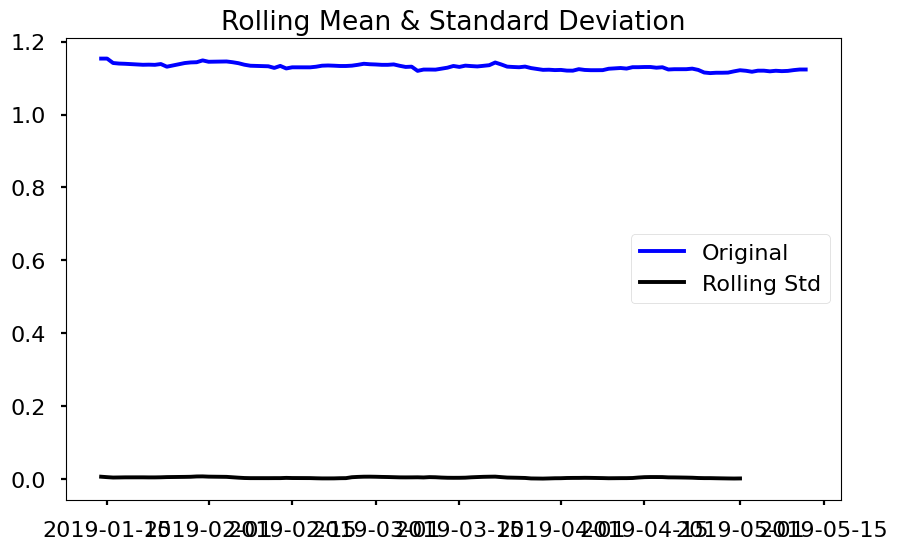

In [321]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [322]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['rate'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  0.065924
p-value                         0.963656
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


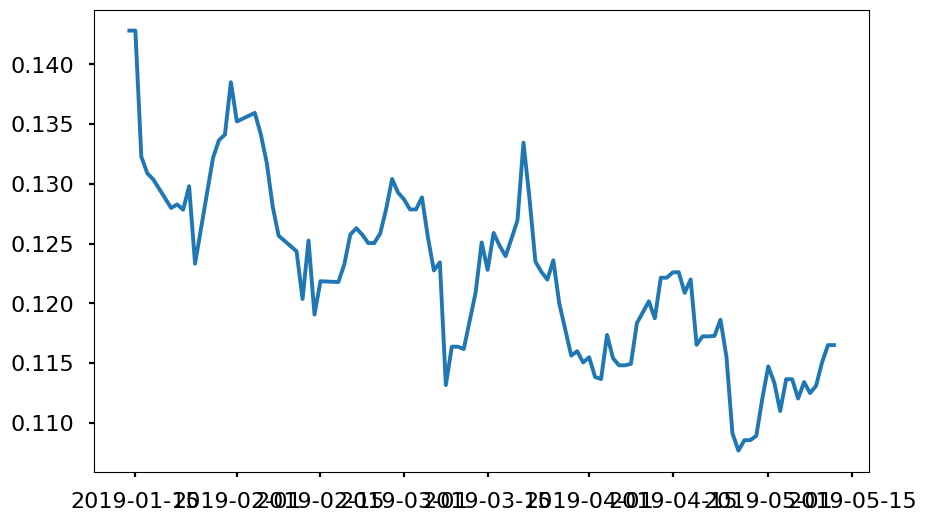

In [323]:


#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)



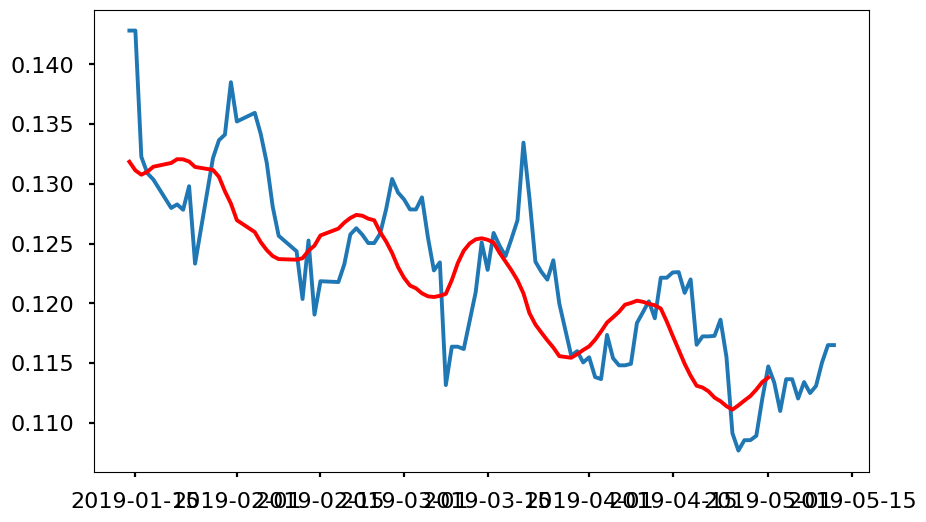

In [324]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [325]:


datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)



,rate
Time Stamp,
2019-05-01,0.000933
2019-04-30,-0.001398
2019-04-29,-0.003864
2019-04-28,-0.003691
2019-04-27,-0.003313
2019-04-26,-0.003782
2019-04-25,-0.001972
2019-04-24,0.004111
2019-04-23,0.006818


In [326]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['rate'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

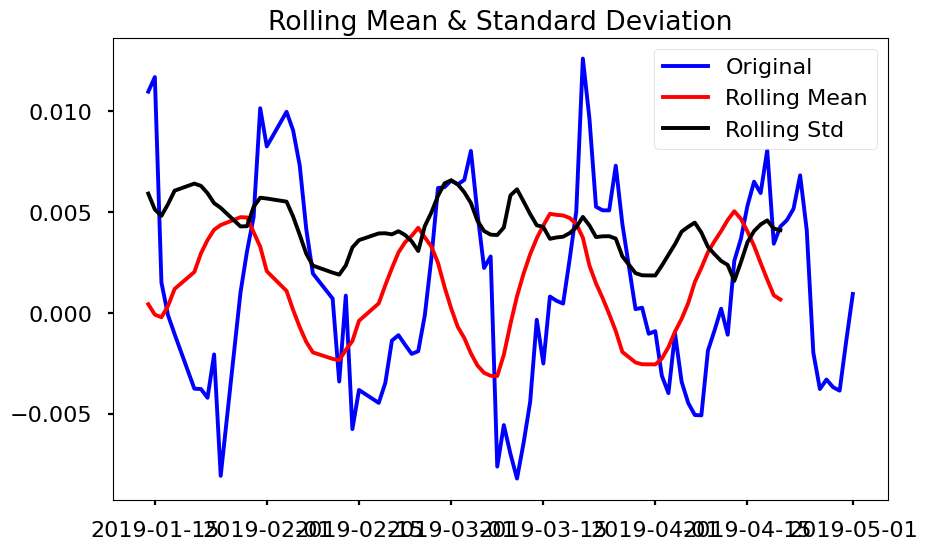

Results of Dickey Fuller Test:
Test Statistic                 -5.643048
p-value                         0.000001
#Lags Used                      7.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


In [327]:
test_stationarity(datasetLogScaleMinusMovingAverage)

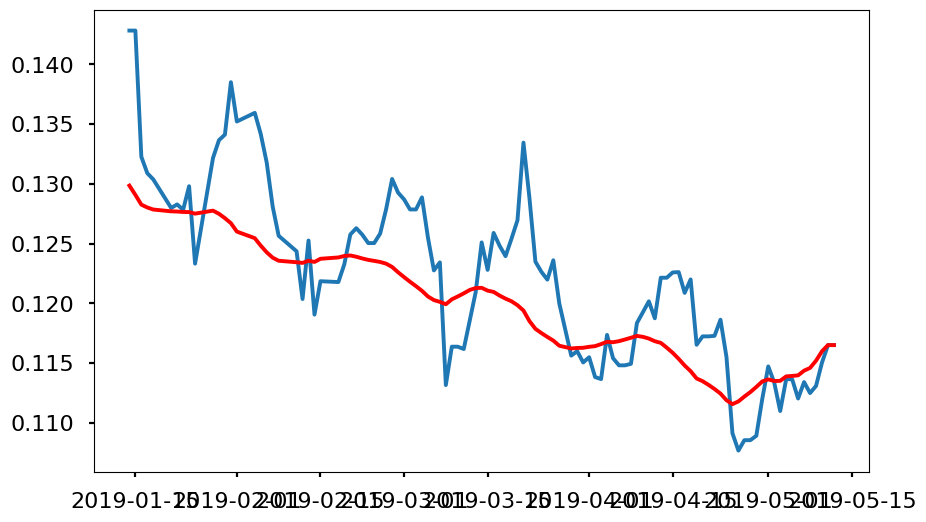

In [328]:


exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')



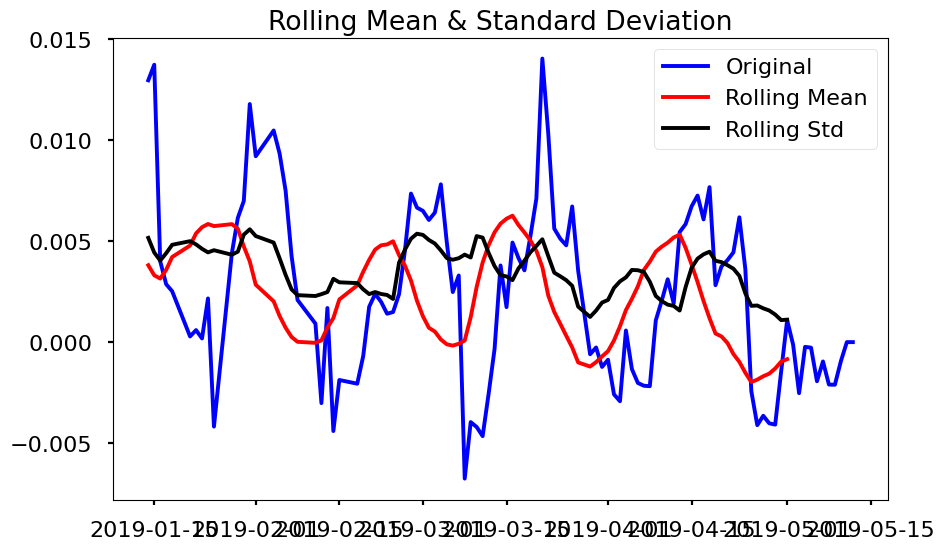

Results of Dickey Fuller Test:
Test Statistic                  -4.301606
p-value                          0.000441
#Lags Used                       7.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [329]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

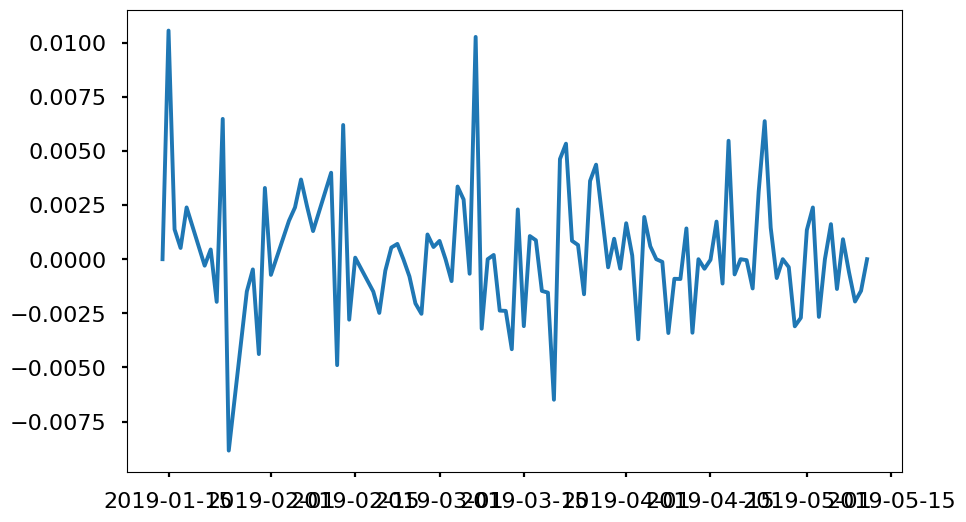

In [330]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

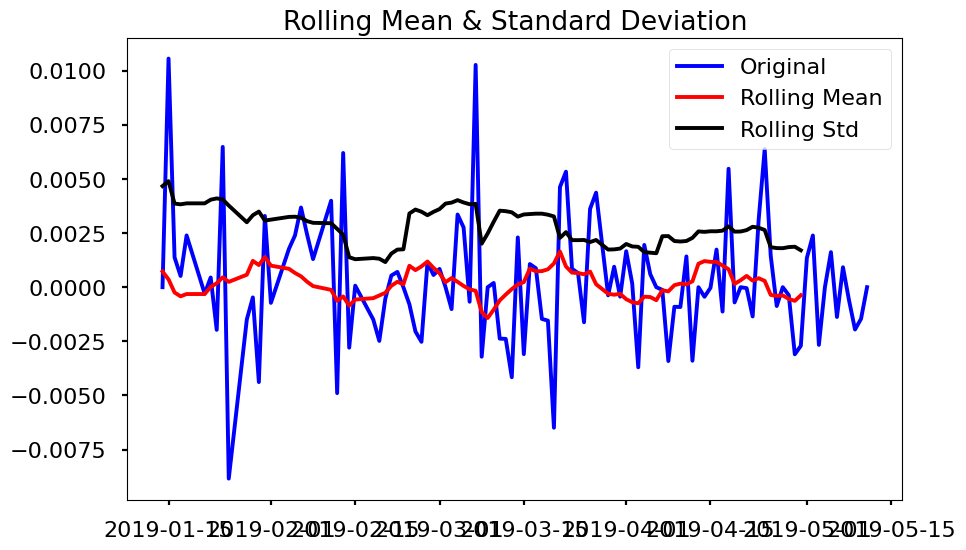

Results of Dickey Fuller Test:
Test Statistic                 -4.634780
p-value                         0.000111
#Lags Used                     10.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [331]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)